# k-Nearest Neighbors

Download the Data Science from Scratch repository into the folder `dsfs`.

In [1]:
import os

if not os.path.isdir('dsfs'):
    !git clone --depth 1 https://github.com/joelgrus/data-science-from-scratch dsfs

Import the needed functions.

In [2]:
from dsfs.scratch.linear_algebra import Vector, distance
from dsfs.scratch.machine_learning import split_data

## The Model

In [3]:
from typing import List
from collections import Counter

def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b']) == 'b'

In [4]:
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4, then 'b'
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

In [5]:
from typing import NamedTuple

class LabeledPoint(NamedTuple):
    point: Vector
    label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

## Example: The Iris Dataset

In [6]:
import requests

data = requests.get(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
)

with open('iris.data', 'w') as f:
    text = data.text.strip() # remove newlines at the end
    f.write(text)

In [7]:
from typing import Dict
import csv
from collections import defaultdict

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader]

# We'll also group just the points by species/label so we can plot them.
points_by_species: Dict[str, List[Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

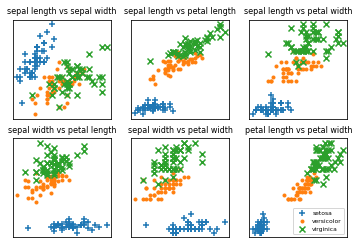

In [8]:
from matplotlib import pyplot as plt

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()  

In [9]:
import random

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

In [10]:
from typing import Tuple

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct)

confusion_matrix

0.9777777777777777


defaultdict(int,
            {('setosa', 'setosa'): 13,
             ('versicolor', 'versicolor'): 15,
             ('virginica', 'virginica'): 16,
             ('virginica', 'versicolor'): 1})

## The Curse of Dimensionality

In [11]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

In [12]:
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

In [13]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

Curse of Dimensionality: 100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


In [14]:
min_avg_ratio = [min_dist / avg_dist
                    for min_dist, avg_dist in zip(min_distances, avg_distances)]

min_avg_ratio

[2.4010264196729895e-05,
 0.012375993376885747,
 0.05866675835687187,
 0.052702840066952916,
 0.13806017036605744,
 0.16706667538692488,
 0.13946376694501153,
 0.21627918375769406,
 0.2584599213183403,
 0.269306360063673,
 0.27670626780046326,
 0.3706318741676572,
 0.26499940923263887,
 0.3552552587706282,
 0.3474871534632107,
 0.42834610882474056,
 0.42466657369159216,
 0.4446491710023277,
 0.535207240511332,
 0.34176993540037365,
 0.5388246061126235,
 0.5058621513898754,
 0.5347436432023157,
 0.5444461514254334,
 0.47597755191184377,
 0.4905464153431202,
 0.5867979218606769,
 0.5123632294260677,
 0.5424819954205379,
 0.5742090130686824,
 0.5897087379993046,
 0.5775736849502905,
 0.5673715611211803,
 0.5449292858365001,
 0.5796885476098184,
 0.6480053723471617,
 0.6602812580026879,
 0.6289471963191565,
 0.6418344464162202,
 0.6158132408201428,
 0.6091619742363008,
 0.664640030446849,
 0.6564359615197871,
 0.6539490799106948,
 0.6429102073843518,
 0.64757033619389,
 0.6497423009935857,